# COMP41680 - Assignment 1
##### Adam Judge - 16343971

## Task 1: Identify one or more suitable web APIs
###### Api Chosen:
A single API chosen for this assignment was the COVID-19 API - https://covid19api.com/


In [1]:
import os
import numpy as np
import urllib.request
import csv
import json
import pandas as pd 
import requests
import time
%matplotlib inline 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

# Task 1: Collect data from chosen API
###### Collect Data:
The following functions are used in the creation of files, Collection of data

In [2]:
def Json2file(Folder, FileName, Data):
    print(f"Writing JSON data to {Folder}/{FileName}")
    with open(Folder+"/"+FileName, "w") as File:
        json.dump(Data, File)
    File.close()

def makeDir(Folder):
    if not os.path.exists(Folder):
        os.mkdir(Folder)
    else:
        print(f"Folder {Folder} already exists!")


#### Raw COVID-19 data will be extracted for all countries in the European Union and written to .json files

In [3]:
countries = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland",
             "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
             "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"]
# 100ks of person per country based on National Estimates
pop=           {"Austria": 8857960,
               "Belgium": 11449656,
               "Bulgaria": 7000039,
               "Croatia": 4105493,
               "Cyprus": 864200,
               "Czechia": 10627794,
               "Denmark": 5837213,
               "Estonia": 1328976,
               "Finland": 5522015,
               "France": 67076000,
               "Germany": 83122889,
               "Greece": 10768193,
               "Hungary": 9771000,
               "Ireland": 4921500,
               "Italy": 60390560,
               "Latvia": 1921300,
               "Lithuania": 2794090,
               "Luxembourg": 626108,
               "Malta": 514564,
               "Netherlands": 17417600,
               "Poland": 38433600,
               "Portugal": 10276617,
               "Romania": 19523621,
               "Slovakia": 5445087,
               "Slovenia": 2070050, 
               "Spain": 46733038,
               "Sweden": 10319601}

In [4]:
FileNames=[]
ErrCnt=0
makeDir("Raw_Data")
RawFolder="./Raw_Data"
# for i, c in enumerate(countries):
#     URL=f"http://api.covid19api.com/total/dayone/country/{c}"
#     response=requests.get(URL)
#     if response.status_code == 200:
#         print(f"Successfully obtained data for {c}")
#         Json2file("./Raw_Data",f"{c}_rawdata.json", response.json())
#         FileNames.append(f"{c}_rawdata.json")
#     else:
#         print(f"Error for country {c}, {response.status_code}")
#         ErrCnt+=1
#     # Delay so as to not request too much in short period of time
#     time.sleep(1)
print(f"Number of errors: {ErrCnt}")

Folder Raw_Data already exists!
Number of errors: 0


## Data Preparation and Modification Functions
##### Parsing Raw Data:
The raw data for each country starts from the first known covid case reported in said country, and the following columns of data are contained in the raw data in order:
* Country
* CountryCode
* Province
* City
* CityCode
* Lat
* Lon
* Confirmed
* Deaths
* Recovered
* Active
* Date

It can be noted that the active and recovered numbers are poor as these numbers are simply not tracked to any reasonable degree of accuracy in the majority of countries.
The Lat and Lon, or latitude and longitude may be discarded, as well as the CountryCode, Province, City, CityCode, Recovered, and Active. These are not of interest in the comparison between european countries.

Additional columns are desired for this such as New Cases, New Deaths, as well as data per 100k of population. These will allow for the comparison between countries with varied population sizes, such as Malta and Germany. These columns may be inferred from the cumulative deaths and confirmed columns as well as the date.

Any missing data such as missing dates will be added to the dataset, with new cases and new deaths being taken as 0 for these periods. The cumulative values will take the previous dates values.

In [5]:
# This function extracts the daily new cases from the total cumulative cases
def getDailyCasesDeaths(df):
    TotalCases=df["Confirmed"].tolist()
    TotalDeaths=df["Deaths"].tolist()
    DailyCases=[]
    DailyDeaths=[]
    negCaseOcc=0
    negDeathOcc=0
    # Iterate through the total confirmed cases
    for i, TC in enumerate(TotalCases):
        #First is the first case(s)
        if i == 0:
            DailyCases.append(TC)
            continue
        
        # Difference between current day and previous days cases    
        newCases=TC-TotalCases[i-1]
        if newCases<0:  
            negCaseOcc+=1
            
        DailyCases.append(newCases)

    for i, TD in enumerate(TotalDeaths):
        #First is the first death(s)
        if i == 0:
            DailyDeaths.append(TD)
            continue
        
        # Difference between current day and previous days deaths    
        newDeaths=TD-TotalDeaths[i-1]
        if newDeaths<0:  
            negDeathOcc+=1
            
        DailyDeaths.append(newDeaths)
        
    return DailyCases, DailyDeaths, negCaseOcc, negDeathOcc

# Returns Deaths, Confirmed, Daily Deaths, Daily Confirmed per 100k of population
def perCapita(df, num):
    #Convert population to number of 100ks of population
    num=num/100000
    confirmedPer=df["Confirmed"]/num
    deathsPer=df["Deaths"]/num
    dailyCasesPer=df["New Cases"]/num
    dailyDeathsPer=df["New Deaths"]/num
    return confirmedPer, deathsPer, dailyCasesPer, dailyDeathsPer

# Function to pad data for missing dates from 2020-01-01 to present
def padDates(df):
    # First date will be 2020-01-01
    nextDate=date.fromisoformat("2020-01-01")
    missingCnt=0
    addedCnt=0
    i=0
    # Check all rows based on Date
    while nextDate != datetime.today().date():
        # If the date is present do nothing
        if(nextDate in df["Date"].values):
            pass
        # If date is missing
        else:
            # If first row, cases deaths and new cases all should be zero
            if i==0:
                row2add=[nextDate, df["Country"][i], 0, 0, 0, 0, 0, 0, 0, 0]
            # If not first row, new cases should be 0, confirmed cases and deaths should be same as prior row
            else:    
                row2add=[nextDate, df["Country"][i], df["Confirmed"][i-1], df["Confirmed per 100k"][i-1], 0, 0, df["Deaths"][i-1],df["Deaths per 100k"][i-1], 0, 0]
                # Missing date found in middle of data and not at beginning
                if df["Confirmed"][i-1] != 0:
                    missingCnt+=1
                    
            # Make a dataframe with new row
            new_df=pd.DataFrame([row2add], columns=df.columns.values)
            #print(f"Adding \"{row2add}\"")
            # Concatenate new row to correct position in dataframe
            df=pd.concat([df[:i], new_df, df[i:]], ignore_index=True)
            addedCnt+=1
            
        i+=1
        nextDate+=timedelta(days=1)
    
    return df, missingCnt, addedCnt

# Want Date First
def reorderCols(df, Cols):
    dftest=df[Cols]
    return dftest

# Function to remove hr/min/sec/TimeZone from Date entries
def removeTime(df):
    dates=[]
    for d in df["Date"]:
        try:
            dates.append(d.date())
        except:
            dates.append(d)
        
    return dates

Processing Data through the usage of the above functions.

In [10]:
Columns2Drop=["CountryCode", "Province", "City", "CityCode", "Lat", "Lon", "Recovered", "Active"]
Cols=["Date", "Country", "Confirmed", "Confirmed per 100k", "New Cases", "New Cases per 100k", "Deaths", "Deaths per 100k", "New Deaths", "New Deaths per 100k"]
negCaseOcc=0
negDeathOcc=0
missingMid=0
missingTot=0
ProcessedDataFolder="./Processed"
FileNamePro=[]
makeDir(ProcessedDataFolder)

# Process data, remove unnecessary columns and append any missing data as appropriate
for country, filename in zip(countries, FileNames):
    # Read raw data
    df=pd.read_json(RawFolder+"/"+filename, orient="records")
    # Drop unnecessary columns
    df=df.drop(Columns2Drop, axis=1)
    # Add new cases and new deaths columns
    df["New Cases"], df["New Deaths"], nc, nd = getDailyCasesDeaths(df)
    #    return confirmedPer, deathsPer, dailyCasesPer, dailyDeathsPer
    df["Confirmed per 100k"], df["Deaths per 100k"], df["New Cases per 100k"], df["New Deaths per 100k"] = perCapita(df,pop[country])

    # Reorder columns in preferred order
    df=reorderCols(df, Cols)
    # Add missing Dates
    df, missingCnt, addedCnt=padDates(df)
    # No interest in hours/mins/secs/timezone
    df["Date"] = removeTime(df)
    df=df.round(decimals=2)
    missingMid+=missingCnt
    missingTot+=addedCnt
    negCaseOcc+=nc
    negDeathOcc+=nd
    fileNamePro=f"{country}_processed.csv"
    FileNamePro.append(fileNamePro)
    # Write processed data to csv file
    #Json2file(ProcessedDataFolder, fileNamePro, df.to_json(date_format = "iso",orient="records"))
    df.to_csv(ProcessedDataFolder + "/" + fileNamePro)
    print("Written for " + country)
    dfnew=df

print(f"Number of missing date entries found after first case: {missingMid}")
print(f"Number of missing date entries found in total: \t{missingTot}")
print(f"Number of days found in total with a drop in cumulative case numbers: {negCaseOcc}")
print(f"Number of days found in total with a drop in cumulative death numbers: {negDeathOcc}")

Folder ./Processed already exists!
Number of missing date entries found after first case: 0
Number of missing date entries found in total: 	0
Number of days found in total with a drop in cumulative case numbers: 0
Number of days found in total with a drop in cumulative death numbers: 0


## Function to plot data of given countries processed dataframe
 This will generate a figure with four subplots with cumulative cases, cumulative deaths, new cases + rolling average, and new deaths + rolling average.

In [98]:
def plotCovidDF(df1):
    Country1=df1["Country"].iloc[0]
    
    df1["Date"]=pd.to_datetime(df1["Date"])
    x=df1["Date"]
    plt.figure(figsize=(16,12));
    tickRange=np.arange(x.iloc[0], x.iloc[-1], timedelta(days=45));
    xlimits=[x.iloc[0], x.iloc[-1]]

    # First Subplot
    plt.subplot(2, 2, 1)
    # Plot
    y=df1["Confirmed per 100k"]
    plt.plot(x ,y, 'k', linewidth="2.5",label=Country1)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Cases per 100k")
    plt.title("Cumulative Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(y)*1.1])
    plt.legend()

    # Second Subplot
    plt.subplot(2,2,2)
    # Plot
    y=df1["Deaths per 100k"]
    plt.plot(x,y,'k', linewidth="2.5", label=Country1)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Deaths per 100k")
    plt.title(f"Cumulative Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(y)*1.1])
    plt.legend()


    # Third Subplot
    plt.subplot(2, 2, 3)
    # Plot
    y=df1["New Cases per 100k"]
    plt.plot(x,y.rolling(7).mean(),"k", linewidth="2.5", label=f"{Country1} 7-Day avg")
    plt.bar(x, y, 1, color='r', label=Country1, alpha=0.75)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Cases per 100k")
    plt.title("Daily New Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(y)*1.1])
    plt.legend()

    # Fourth Subplot
    plt.subplot(2, 2, 4)
    # Plot
    y=df1["New Deaths per 100k"]
    plt.plot(x, y.rolling(7).mean(), "k", linewidth="2.5", label=f"{Country1} 7-Day avg")
    plt.bar(x, y, 1, color='r', label=Country1, alpha=0.75)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Deaths per 100k")
    plt.title("Daily New Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(y)*1.1])
    plt.legend()

    plt.tight_layout()

## Function to plot data to compare two different country dataframes
 This will generate a figure with four subplots with cumulative cases, cumulative deaths, new cases + rolling average, and new deaths + rolling average.

In [99]:
def compareCovidDF(df1, df2):
    Country1=df1["Country"].iloc[0]
    Country2=df2["Country"].iloc[0]
    
    #Ensure time fields are in datetime
    df1["Date"]=pd.to_datetime(df1["Date"])
    df2["Date"]=pd.to_datetime(df2["Date"])
    x1=df1["Date"]
    x2=df2["Date"]
    plt.figure(figsize=(16,12));
    tickRange=np.arange(x1.iloc[0], x1.iloc[-1], timedelta(days=45));
    xlimits=[x1.iloc[0], x1.iloc[-1]]

    # First Subplot
    plt.subplot(2, 2, 1)
    # Plot
    y1=df1["Confirmed per 100k"]
    y2=df2["Confirmed per 100k"]
    plt.plot(x1 ,y1, 'g', linewidth="2.5", label=Country1)
    plt.plot(x2 ,y2, 'r', linewidth="2.5", label=Country2)
    plt.fill_between(x1,y1,y2, where=y1>y2, facecolor="green", alpha=0.4)
    plt.fill_between(x1,y1,y2, where=y1<=y2, facecolor="red", alpha=0.4)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Cases per 100k")
    plt.title("Cumulative Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(max(y1), max(y2))*1.1])
    plt.legend()

    # Second Subplot
    plt.subplot(2,2,2)
    # Plot
    y1=df1["Deaths per 100k"]
    y2=df2["Deaths per 100k"]
    plt.plot(x1,y1,'g', linewidth="2.5", label=Country1)
    plt.plot(x2,y2,'r', linewidth="2.5", label=Country2)
    plt.fill_between(x1,y1,y2, where=y1>y2, facecolor="green", alpha=0.4)
    plt.fill_between(x1,y1,y2, where=y1<=y2, facecolor="red", alpha=0.4)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Deaths per 100k")
    plt.title(f"Cumulative Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(max(y1), max(y2))*1.1])
    plt.legend()


    # Third Subplot
    plt.subplot(2, 2, 3)
    # Plot
    y1=df1["New Cases per 100k"]
    y2=df2["New Cases per 100k"]
    plt.plot(x1,y1.rolling(7).mean(),"g", linewidth="2.5", label=f"{Country1} 7-Day avg")
    plt.plot(x2,y2.rolling(7).mean(),"r", linewidth="2.5", label=f"{Country2} 7-Day avg")
    plt.bar(x1, y1, 1, color='g', label=Country1, alpha=0.5)
    plt.bar(x2, y2, 1, color='r', label=Country2, alpha=0.5)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Cases per 100k")
    plt.title("Daily New Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(max(y1), max(y2))*1.1])
    plt.legend()

    # Fourth Subplot
    plt.subplot(2, 2, 4)
    # Plot
    y1=df1["New Deaths per 100k"]
    y2=df2["New Deaths per 100k"]
    plt.plot(x1, y1.rolling(7).mean(), "g", linewidth="2.5", label=f"{Country1} 7-Day avg")
    plt.plot(x2,y2.rolling(7).mean(), "r", linewidth="2.5", label=f"{Country2} 7-Day avg")
    plt.bar(x1, y1, 1, color='g', label=Country1, alpha=0.5)
    plt.bar(x2, y2, 1, color='r', label=Country2, alpha=0.5)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Deaths per 100k")
    plt.title("Daily New Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(max(y1), max(y2))*1.1])
    plt.legend()

    plt.tight_layout()

## Example output for last country alphabetically
This will demonstrate Sweden's COVID-19 Data. We can note that just after the 31st of March 2020 there is a drop in cumulative deaths, this is accurate and represents denotified deaths and can be noticed in official charts.

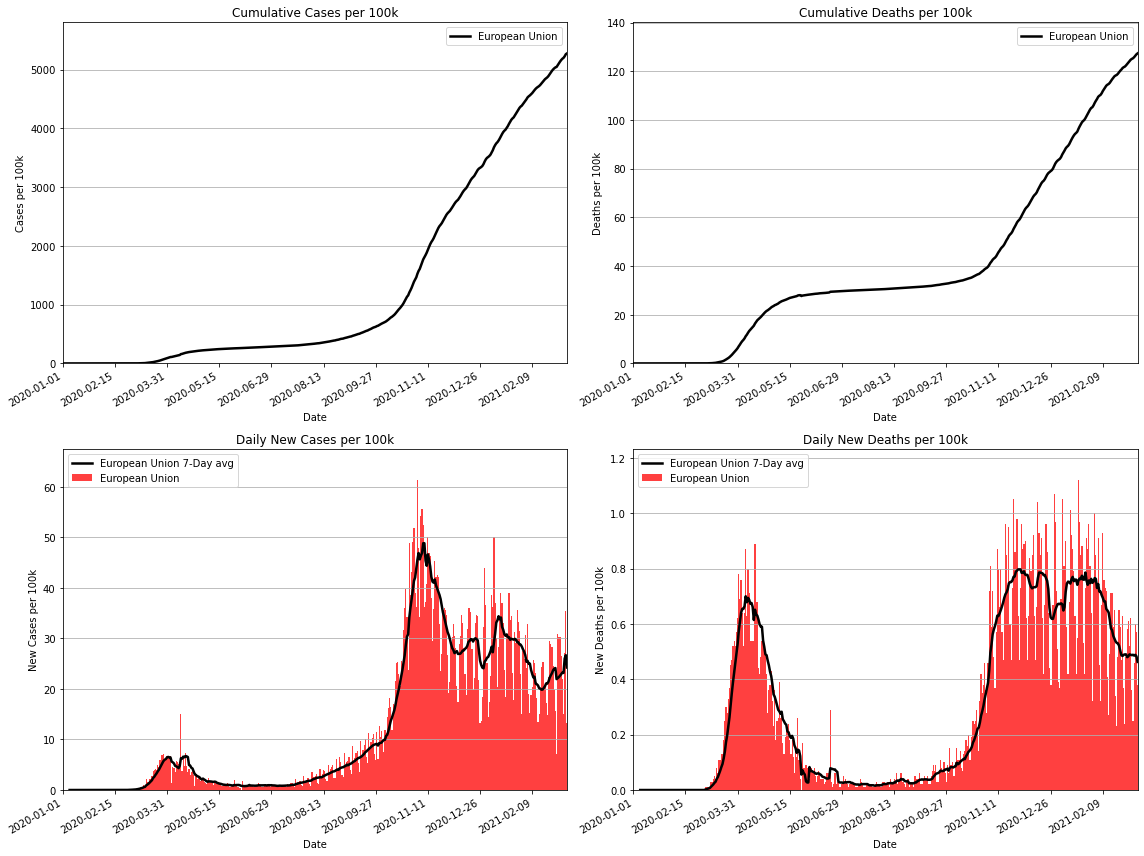

In [100]:
plotCovidDF(dfEU)

### Generate EU averages
A mean dataframe can be generated which is weighted by each countries population. This will allow for a good comparison of Ireland's handling of the pandemic with respect to the European Union Average. This average will include Ireland.

In [64]:
ProcessedDataFolder="./Processed"
length=df.index.stop
Confirmed   = [0]*length
ConfirmedPer= [0]*length
NewCases    = [0]*length
NewCasesPer = [0]*length
Deaths      = [0]*length
DeathsPer   = [0]*length
NewDeaths   = [0]*length
NewDeathsPer= [0]*length

EUpop=sum(pop.values())
dfEU = pd.DataFrame(columns=Cols)
country=["European Union"]*length

for c in countries:
    df=pd.read_csv(ProcessedDataFolder + f"/{c}_processed.csv")
    # Ratio of population of C to EU
    pop_cEU=pop[c]/EUpop
    for i in range(df.index.stop):
        Confirmed[i]   +=df["Confirmed"][i]*pop_cEU
        ConfirmedPer[i]+=df["Confirmed per 100k"][i]*pop_cEU
        NewCases[i]    +=df["New Cases"][i]*pop_cEU
        NewCasesPer[i] +=df["New Cases per 100k"][i]*pop_cEU
        Deaths[i]      +=df["Deaths"][i]*pop_cEU
        DeathsPer[i]   +=df["Deaths per 100k"][i]*pop_cEU
        NewDeaths[i]   +=df["New Deaths"][i]*pop_cEU
        NewDeathsPer[i]+=df["New Deaths per 100k"][i]*pop_cEU
        
dfEU["Date"]=df["Date"]
dfEU["Country"]=country
dfEU["Confirmed"]=Confirmed
dfEU["Confirmed per 100k"]=ConfirmedPer
dfEU["New Cases"]=NewCases
dfEU["New Cases per 100k"]=NewCasesPer
dfEU["Deaths"]=Deaths
dfEU["Deaths per 100k"]=DeathsPer
dfEU["New Deaths"]=NewDeaths
dfEU["New Deaths per 100k"]=NewDeathsPer
dfEU=dfEU.round(decimals=2)
dfEU.to_csv(ProcessedDataFolder + "/european_union_processed.csv")

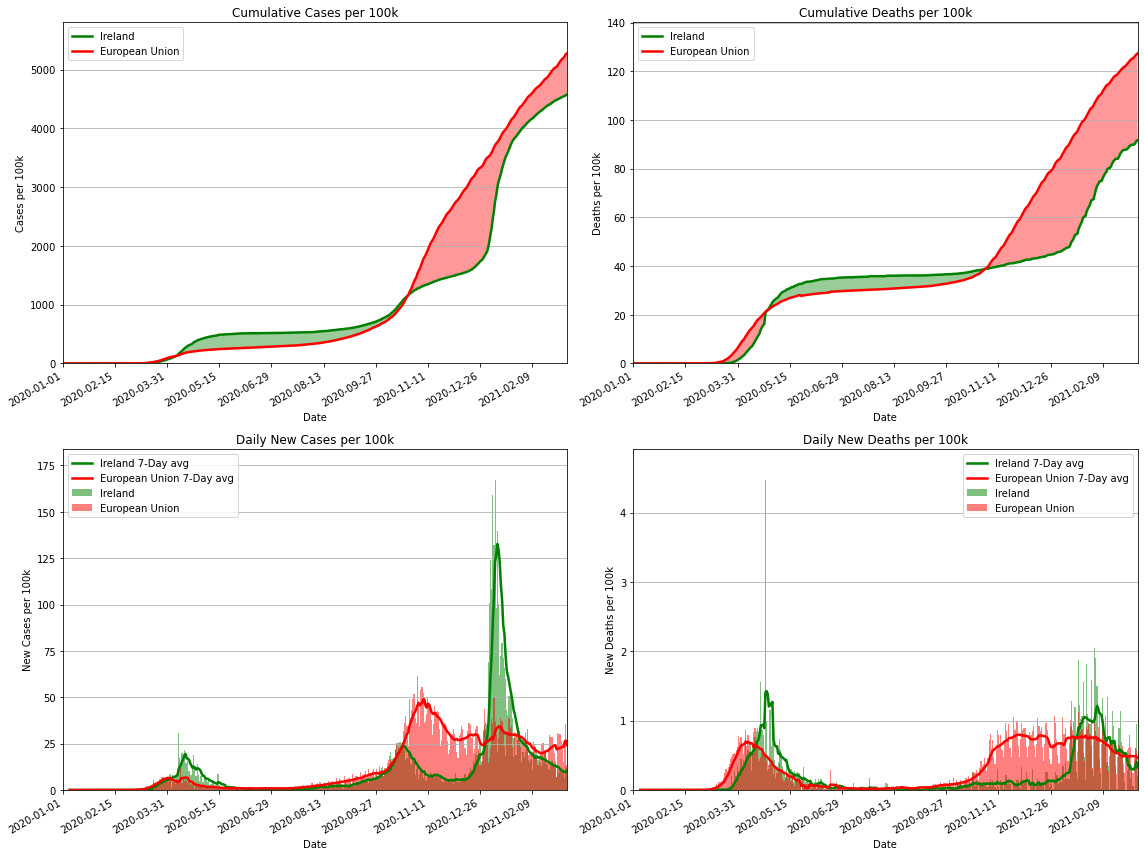

In [101]:
df=pd.read_csv(ProcessedDataFolder + f"/ireland_processed.csv")
dfEU=pd.read_csv(ProcessedDataFolder + f"/european_union_processed.csv")

compareCovidDF(df, dfEU)